### 循环神经网络模型模型：Encoder-Decoder with LSTM cell

先按EmergingScore前N年的线性回归趋势将术语分为正负两组，然后为各组训练单独的模型，将预测结果拼合

0.734 gene MAE

0.719 transplant MAE

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/es_with_decay.array'
transplant_arr_path = r'../output/transplant/es_with_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 10)
Shape of the transplant array: (5141, 17, 10)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 10)
Shape of the transplant array: (5141, 16, 10)


### Extra：按照前N年的Emerging Score的趋势进行区分

要先划分训练集和测试集，然后才能够和其他模型横评

共训练两个模型，将其预测结果合并

In [4]:
def split_data_by_trend(data, targets):
    up_data = []
    down_data = []
    up_target = []
    down_target = []
    
    for i in range(len(data)):
        a, b = np.polyfit(range(len(data[i])), data[i, :, -2].reshape(-1), 1)
        if a > 0:
            up_data.append(data[i])
            up_target.append(targets[i])
        else:
            down_data.append(data[i])
            down_target.append(targets[i])
    return np.array(up_data), np.array(up_target), np.array(down_data), np.array(down_target)

In [11]:
# scaler, data = scale_data(gene_arr, 'standard')
scaler, data = scale_data(transplant_arr, 'standard')

X_train, X_test, y_train, y_test = split_data(data, n_input=11, ratio=0.2)

X_train1, y_train1, X_train2, y_train2 = split_data_by_trend(X_train, y_train)
X_test1, y_test1, X_test2, y_test2 = split_data_by_trend(X_test, y_test)

print('X_trains shape：', X_train1.shape, X_train2.shape)
print('Y_trains shape：', y_train1.shape, y_train2.shape)
print()
print('X_tests shape：', X_test1.shape, X_test2.shape)
print('Y_tests shape：', y_test1.shape, y_test2.shape)

X_trains shape： (3527, 11, 10) (585, 11, 10)
Y_trains shape： (3527, 5) (585, 5)

X_tests shape： (888, 11, 10) (141, 11, 10)
Y_tests shape： (888, 5) (141, 5)


### 检查各组内的特征相似性

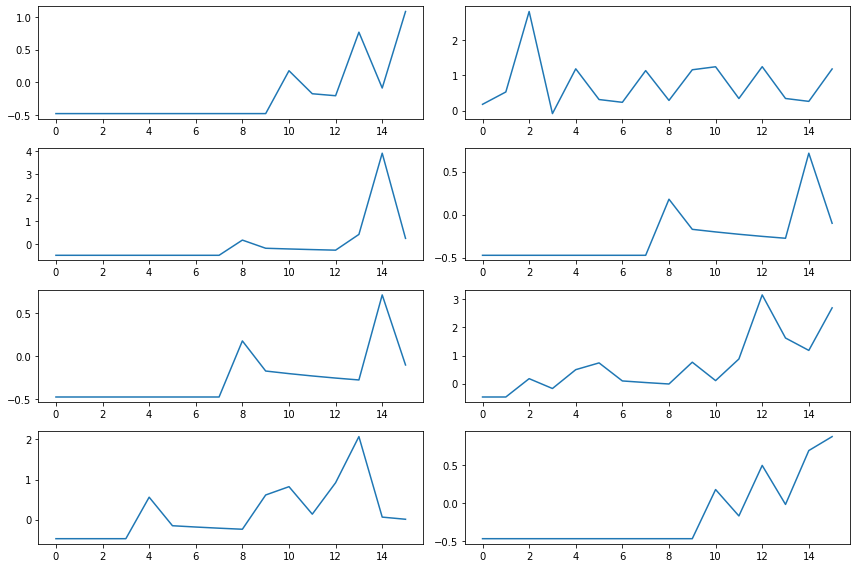

In [12]:
plot_datax, plot_datay = X_train1, y_train1
ids = random.sample(range(len(plot_datax)), 10)

plt.figure(figsize=(12,8))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(np.arange(16), np.concatenate((plot_datax[ids[i], :, -2], plot_datay[ids[i]])))
plt.tight_layout()
plt.show()

### 构建模型

In [13]:
def build_encoder_decoder_model(lstm_units, dense_units, lr):
    model = keras.models.Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(RepeatVector(y_train.shape[1]))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(dense_units, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    optimizer=keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mae', optimizer=optimizer)
    return model

训练

In [12]:
train_xs = [X_train1, X_train2]
train_ys = [y_train1, y_train2]
test_xs = [X_test1, X_test2]
test_ys = [y_test1, y_test2]
i_s = [1, 2]

In [15]:


for train_x, train_y, test_x, test_y, i in zip(train_xs, train_ys, test_xs, test_ys, i_s):
    model = build_encoder_decoder_model(256, 256, 0.0001)
    history = model.fit(train_x, train_y, epochs=100, batch_size=16, verbose=1, validation_data=(test_x, test_y), 
                   callbacks=[
                       ModelCheckpoint('rnn_model{}_checkpoint.h5'.format(i), save_best_only=True,verbose=1)
                   ])


Train on 990 samples, validate on 254 samples
Epoch 1/100
976/990 [============================>.] - ETA: 0s - loss: 0.9314
Epoch 00001: val_loss improved from inf to 0.93784, saving model to rnn_model1_checkpoint.h5
990/990 [==============================] - 17s 17ms/sample - loss: 0.9354 - val_loss: 0.9378
Epoch 2/100
976/990 [============================>.] - ETA: 0s - loss: 0.8984
Epoch 00002: val_loss improved from 0.93784 to 0.93536, saving model to rnn_model1_checkpoint.h5
990/990 [==============================] - 5s 5ms/sample - loss: 0.8974 - val_loss: 0.9354
Epoch 3/100
976/990 [============================>.] - ETA: 0s - loss: 0.8841
Epoch 00003: val_loss did not improve from 0.93536
990/990 [==============================] - 5s 5ms/sample - loss: 0.8819 - val_loss: 0.9369
Epoch 4/100
976/990 [============================>.] - ETA: 0s - loss: 0.8716
Epoch 00004: val_loss improved from 0.93536 to 0.91226, saving model to rnn_model1_checkpoint.h5
990/990 [====================

Epoch 35/100
976/990 [============================>.] - ETA: 0s - loss: 0.7982
Epoch 00035: val_loss did not improve from 0.85809
990/990 [==============================] - 5s 5ms/sample - loss: 0.8014 - val_loss: 0.8612
Epoch 36/100
976/990 [============================>.] - ETA: 0s - loss: 0.8039
Epoch 00036: val_loss did not improve from 0.85809
990/990 [==============================] - 5s 5ms/sample - loss: 0.8014 - val_loss: 0.8641
Epoch 37/100
976/990 [============================>.] - ETA: 0s - loss: 0.8006
Epoch 00037: val_loss improved from 0.85809 to 0.85792, saving model to rnn_model1_checkpoint.h5
990/990 [==============================] - 5s 5ms/sample - loss: 0.7999 - val_loss: 0.8579
Epoch 38/100
976/990 [============================>.] - ETA: 0s - loss: 0.8001
Epoch 00038: val_loss did not improve from 0.85792
990/990 [==============================] - 5s 5ms/sample - loss: 0.7992 - val_loss: 0.8640
Epoch 39/100
976/990 [============================>.] - ETA: 0s - loss

Epoch 71/100
976/990 [============================>.] - ETA: 0s - loss: 0.7903
Epoch 00071: val_loss did not improve from 0.85178
990/990 [==============================] - 5s 5ms/sample - loss: 0.7906 - val_loss: 0.8615
Epoch 72/100
976/990 [============================>.] - ETA: 0s - loss: 0.7898
Epoch 00072: val_loss did not improve from 0.85178
990/990 [==============================] - 5s 5ms/sample - loss: 0.7884 - val_loss: 0.8557
Epoch 73/100
976/990 [============================>.] - ETA: 0s - loss: 0.7881
Epoch 00073: val_loss did not improve from 0.85178
990/990 [==============================] - 5s 5ms/sample - loss: 0.7902 - val_loss: 0.8547
Epoch 74/100
976/990 [============================>.] - ETA: 0s - loss: 0.7926
Epoch 00074: val_loss did not improve from 0.85178
990/990 [==============================] - 5s 5ms/sample - loss: 0.7884 - val_loss: 0.8576
Epoch 75/100
976/990 [============================>.] - ETA: 0s - loss: 0.7863
Epoch 00075: val_loss did not improve

Epoch 7/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5594
Epoch 00007: val_loss did not improve from 0.54740
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5592 - val_loss: 0.5514
Epoch 8/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5574
Epoch 00008: val_loss did not improve from 0.54740
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5569 - val_loss: 0.5481
Epoch 9/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5564
Epoch 00009: val_loss did not improve from 0.54740
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5566 - val_loss: 0.5560
Epoch 10/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5577
Epoch 00010: val_loss did not improve from 0.54740
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5571 - val_loss: 0.5533
Epoch 11/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5555
Epoch 00011: val_loss 

Epoch 43/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5503
Epoch 00043: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5514 - val_loss: 0.5457
Epoch 44/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5527
Epoch 00044: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5519 - val_loss: 0.5439
Epoch 45/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5532
Epoch 00045: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5522 - val_loss: 0.5468
Epoch 46/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5498
Epoch 00046: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5518 - val_loss: 0.5549
Epoch 47/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5515
Epoch 00047: val_lo

Epoch 80/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5476
Epoch 00080: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5476 - val_loss: 0.5483
Epoch 81/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5488
Epoch 00081: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5480 - val_loss: 0.5447
Epoch 82/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5464
Epoch 00082: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5477 - val_loss: 0.5457
Epoch 83/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5454
Epoch 00083: val_loss did not improve from 0.54113
1124/1124 [==============================] - 6s 5ms/sample - loss: 0.5477 - val_loss: 0.5575
Epoch 84/100
1120/1124 [============================>.] - ETA: 0s - loss: 0.5491
Epoch 00084: val_lo

预测

In [13]:
models = []
for i in range(1, 3):
    models.append(keras.models.load_model('trained_models/transplant_rnn/rnn_model{}_checkpoint.h5'.format(i)))

In [14]:
y_preds = []
y_tests = []
for i in range(len(models)):
    y_preds.append(models[i].predict(test_xs[i]).reshape(test_ys[i].shape))
    y_tests.append(test_ys[i])
y_pred = np.concatenate(y_preds)
y_test = np.concatenate(y_tests)

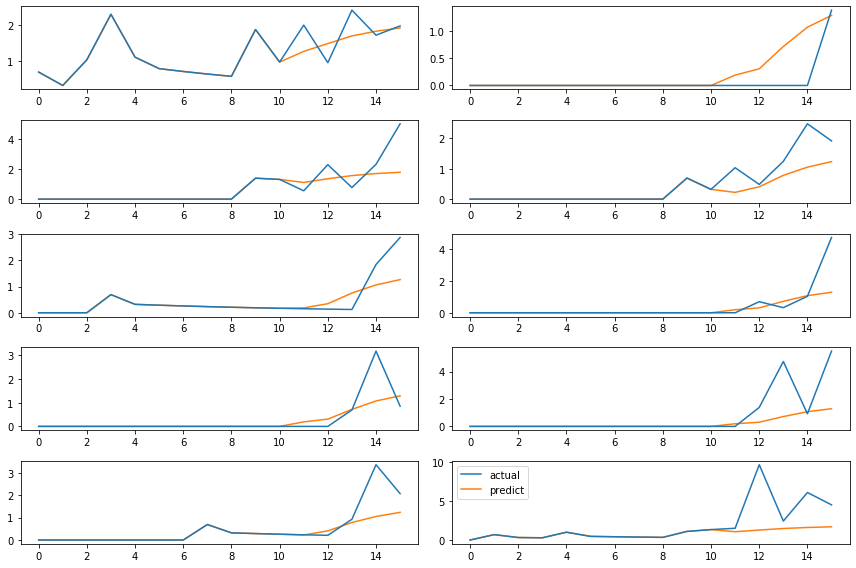

In [24]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_test[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_test[ids[i]].reshape(-1), axis=0))), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_test[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_pred[ids[i]].reshape(-1), axis=0))), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

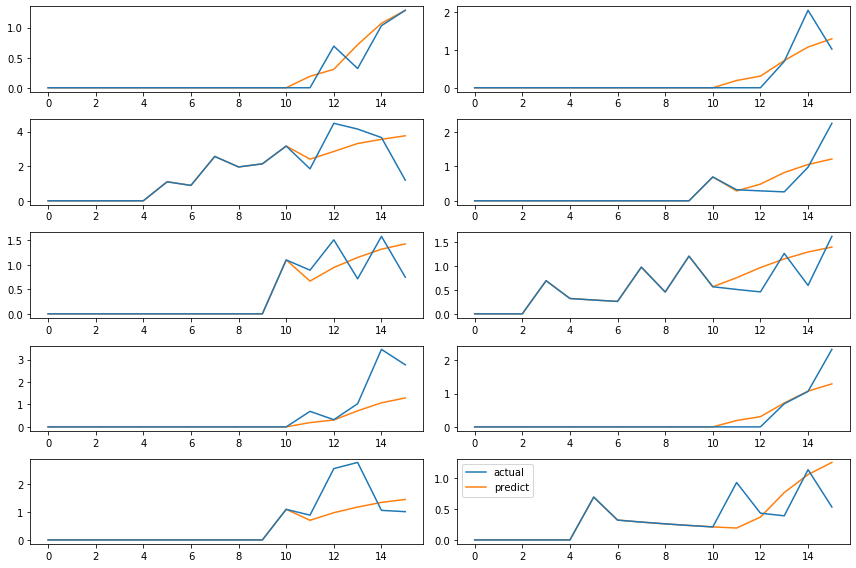

In [26]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_train[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_train[ids[i]].reshape(-1), axis=0))), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_train[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(train_pred[ids[i]].reshape(-1), axis=0))), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

MAE: 0.7192346001736205
MAE: [0.6697189  0.72479672 0.73988431 0.69223097 0.76954211]


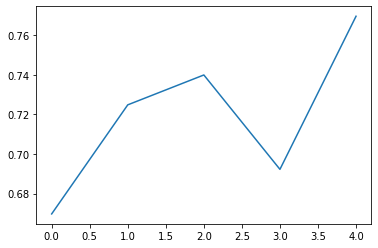

NDCG: 0.33280203761355787
NDCG: [0.13928276219462946, 0.0013482628975115176, 0.07072932422014411, 0.04392646434140691, 0.15725649688440507]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


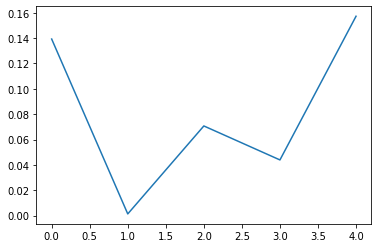

RMSE: 1.1724074325719944
RMSE: [1.10674862 1.22650644 1.19966365 1.13940612 1.1857682 ]


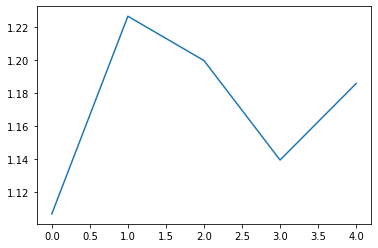

In [15]:
metrics = ['mae', 'ndcg','rmse']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred.reshape(len(y_test), -1), scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [34]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59        27
         1.0       0.69      0.67      0.68      3248
         2.0       0.18      0.18      0.18      1059
         3.0       0.40      0.34      0.37       548
         4.0       0.21      0.28      0.24       263

    accuracy                           0.52      5145
   macro avg       0.38      0.50      0.41      5145
weighted avg       0.53      0.52      0.52      5145

